<a href="https://colab.research.google.com/github/slucey-cs-cmu-edu/RVSS26/blob/main/Conditioning_BN_LN_norm_growth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditioning and Norm Growth in Deep MLPs: BatchNorm and LayerNorm

MNIST accuracy is not the point here. The goal is to **visualize conditioning**.

We use the same language as the earlier notebooks:
- hidden representations are **hidden vector units**
- depth corresponds to **repeated composition**
- the nonlinearity is denoted by **η(·)** (we use ReLU)

What we measure:
- the **ℓ2 norm** of each hidden vector unit as we go deeper
- how **BatchNorm** and **LayerNorm** change that norm growth

In many deep networks, poor conditioning shows up as hidden vector norms drifting (often growing) with depth.


## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


## Setup

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.manual_seed(0)


Using device: cpu


## Deep MLP as repeated hidden vector updates

We build a deep MLP of depth `L` where each hidden vector unit update is:

$$
h^{(\ell+1)} = \eta\big(\mathrm{Norm}(W^{(\ell)} h^{(\ell)})\big)
$$

`Norm(·)` is either:
- identity (no normalization)
- BatchNorm (across samples)
- LayerNorm (within each hidden vector unit)


In [3]:
class DeepMLP(nn.Module):
    def __init__(self, input_dim=28*28, hidden=256, depth=20, norm=None):
        super().__init__()
        self.depth = depth
        self.norm_type = norm

        self.fcs = nn.ModuleList()
        self.norms = nn.ModuleList()

        d_in = input_dim
        for _ in range(depth):
            self.fcs.append(nn.Linear(d_in, hidden))
            if norm == "bn":
                self.norms.append(nn.BatchNorm1d(hidden))
            elif norm == "ln":
                self.norms.append(nn.LayerNorm(hidden))
            else:
                self.norms.append(nn.Identity())
            d_in = hidden

        self.out = nn.Linear(hidden, 10)

    def forward_with_norms(self, x):
        # returns logits and a list of per-layer hidden vector norms (averaged over batch)
        x = x.view(x.size(0), -1)
        norms = []
        h = x
        for fc, nm in zip(self.fcs, self.norms):
            h = fc(h)
            h = nm(h)
            # record mean L2 norm over the batch
            norms.append(h.norm(p=2, dim=1).mean().detach())
            h = F.relu(h)  # η(·)
        logits = self.out(h)
        return logits, torch.stack(norms)

    def forward(self, x):
        logits, _ = self.forward_with_norms(x)
        return logits


## A simple way to see the effect: feed random inputs

To isolate conditioning, we first use random inputs shaped like MNIST images:
- no dataset download needed
- the point is just to see how the representation behaves with depth


In [4]:
def sample_inputs(batch_size=256):
    # Random "MNIST-shaped" inputs in [0,1]
    x = torch.rand(batch_size, 1, 28, 28, device=device)
    return x

def measure_norm_profile(depth=30, hidden=256, norm=None, batch_size=256, mode="train"):
    model = DeepMLP(hidden=hidden, depth=depth, norm=norm).to(device)
    if mode == "train":
        model.train()
    else:
        model.eval()

    x = sample_inputs(batch_size=batch_size)
    _, norms = model.forward_with_norms(x)
    return norms.cpu()

# Quick sanity check
norms = measure_norm_profile(depth=10, hidden=128, norm=None)
print(norms.shape)


torch.Size([10])


## Plot: norm growth with depth (no norm vs BatchNorm vs LayerNorm)

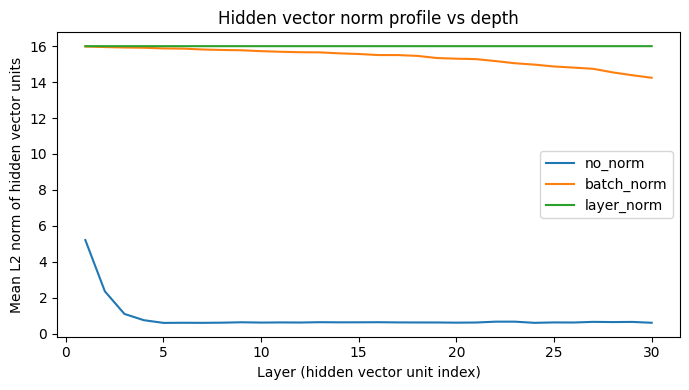

In [5]:
depth = 30
hidden = 256
batch_size = 256

profiles = {
    "no_norm": measure_norm_profile(depth=depth, hidden=hidden, norm=None, batch_size=batch_size, mode="train"),
    "batch_norm": measure_norm_profile(depth=depth, hidden=hidden, norm="bn", batch_size=batch_size, mode="train"),
    "layer_norm": measure_norm_profile(depth=depth, hidden=hidden, norm="ln", batch_size=batch_size, mode="train"),
}

plt.figure(figsize=(7,4))
for name, prof in profiles.items():
    plt.plot(range(1, depth+1), prof.numpy(), label=name)

plt.xlabel("Layer (hidden vector unit index)")
plt.ylabel("Mean L2 norm of hidden vector units")
plt.title("Hidden vector norm profile vs depth")
plt.legend()
plt.tight_layout()
plt.show()


## Why LayerNorm flattens the norm growth curve

In this notebook we plot, at each depth ℓ, the **mean ℓ2 norm** of the hidden vector unit:

$$
\mathbb{E}_{\text{batch}}\big[\|h^{(\ell)}\|_2\big].
$$

LayerNorm is computed **within each hidden vector unit** $h\in\mathbb{R}^m$:

$$
\mathrm{LN}(h)=\gamma\odot\frac{h-\mu(h)}{\sqrt{\sigma^2(h)+\varepsilon}}+\beta,
$$

where $\mu(h)$ and $\sigma^2(h)$ are taken over the coordinates of the same vector.

If we ignore the learnable affine parameters (take $\gamma=1$, $\beta=0$), then after LayerNorm the coordinates have unit variance *within the vector*, which implies:

$$
\|\mathrm{LN}(h)\|_2^2 \approx m
\quad\Rightarrow\quad
\|\mathrm{LN}(h)\|_2 \approx \sqrt{m}.
$$

So LayerNorm connects **directly** to the quantity we are plotting: it tends to keep the hidden vector norm close to a constant (up to scaling by $\gamma$).


In [ ]:
# Add a reference line at sqrt(m) for LayerNorm intuition
# Here, m is the hidden dimension (the size of each hidden vector unit).

m = hidden
ref = (m ** 0.5)

plt.figure(figsize=(7,4))
for name, prof in profiles.items():
    plt.plot(range(1, depth+1), prof.numpy(), label=name)

# Reference line: sqrt(m)
plt.plot(range(1, depth+1), [ref]*depth, linestyle='--', label=r"reference: $\sqrt{m}$")

plt.xlabel("Layer (hidden vector unit index)")
plt.ylabel("Mean L2 norm of hidden vector units")
plt.title("Hidden vector norm profile vs depth (with LayerNorm reference)")
plt.legend()
plt.tight_layout()
plt.show()

print("Hidden dimension m =", m)
print("Reference sqrt(m)  =", ref)


## Optional: make the effect stronger by increasing depth

If the curves look too similar (depending on init / hidden size), try:
- `depth = 60`
- `hidden = 512`

The goal is simply to show that normalization acts as a **conditioning operator** that can
stabilize the scale of hidden vector units through depth.


## What about MNIST itself?

If you want to connect back to the MNIST setting without relying on accuracy,
you can measure the same norm profiles using a real minibatch. This keeps the story aligned
with your earlier notebook: *norm growth across layers and how BN slows it down*.


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)

x_batch, y_batch = next(iter(train_loader))
x_batch = x_batch.to(device)

depth = 30
hidden = 256

def measure_on_batch(x, depth=30, hidden=256, norm=None, mode="train"):
    model = DeepMLP(hidden=hidden, depth=depth, norm=norm).to(device)
    if mode == "train":
        model.train()
    else:
        model.eval()
    _, norms = model.forward_with_norms(x)
    return norms.cpu()

profiles_mnist = {
    "no_norm": measure_on_batch(x_batch, depth=depth, hidden=hidden, norm=None, mode="train"),
    "batch_norm": measure_on_batch(x_batch, depth=depth, hidden=hidden, norm="bn", mode="train"),
    "layer_norm": measure_on_batch(x_batch, depth=depth, hidden=hidden, norm="ln", mode="train"),
}

plt.figure(figsize=(7,4))
for name, prof in profiles_mnist.items():
    plt.plot(range(1, depth+1), prof.numpy(), label=name)

plt.xlabel("Layer (hidden vector unit index)")
plt.ylabel("Mean L2 norm of hidden vector units")
plt.title("Hidden vector norm profile vs depth (MNIST minibatch)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Add the same sqrt(m) reference line for the MNIST minibatch plot
m = hidden
ref = (m ** 0.5)

plt.figure(figsize=(7,4))
for name, prof in profiles_mnist.items():
    plt.plot(range(1, depth+1), prof.numpy(), label=name)

plt.plot(range(1, depth+1), [ref]*depth, linestyle='--', label=r"reference: $\sqrt{m}$")

plt.xlabel("Layer (hidden vector unit index)")
plt.ylabel("Mean L2 norm of hidden vector units")
plt.title("Hidden vector norm profile vs depth (MNIST minibatch, with reference)")
plt.legend()
plt.tight_layout()
plt.show()

print("Hidden dimension m =", m)
print("Reference sqrt(m)  =", ref)


## Interpretation (minimal)

- The network architecture is the same; only the **conditioning operator** changes.
- Without normalization, hidden vector norms can drift with depth (often growing).
- BatchNorm and LayerNorm tend to reduce that drift by enforcing a more stable representation scale.

This is the core motivation: normalization primarily affects **conditioning** of deep compositions.
